In [3]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

from itertools import chain
import shapely.vectorized as sv

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_statistic as ART_sta
from function import ART_downscale as ART_down

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## TEST TO APPLY BIAS CORRECTION FOR RSR USING ONLY 1 SEED

In [4]:
# correction, nameout, label = 'Linear-Regression', 'LRc', 'Linear Regression'
correction, nameout, label = 'Log-Linear-Regression', 'LLc', 'Log-Linear Regression'
# correction, nameout, label = 'Quantile Delta Mapping', 'QDM', 'Quantile Delta Mapping'
# correction, nameout, label = 'Cummulative Distribution', 'CDFt', 'Cummulative Distribution'
# correction, nameout, label = 'Quantile-Quantile', 'QQc', 'Quantile Quantile Mapping'

In [5]:
product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CHIRPS', '1dy'
# product, time_reso = 'GSMaP', '3h'

In [6]:
apply = 'PARAM'
frac = 0.7
seed = 7

In [7]:
COMPUTERNAME = os.environ['COMPUTERNAME']
# print(f'Computer     : {COMPUTERNAME}')

if COMPUTERNAME == 'BR_DELL':
    dir_font = os.path.join('/','run')
else:
    dir_font = os.path.join('/')

veneto_dir = os.path.join(dir_font,'media','arturo','T9','Data','shapes','Europa','Italy')

# ==================================================================================================
# LOAD ITALY SHAPEFILE
if os.path.exists(veneto_dir):
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

obs_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC')
weibul_base = os.path.join(dir_font,'media','arturo','T9','Data','Italy','Rain_Gauges_QC','Weibull','1dy')

sat_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')
# ENS_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_ENSEMBLE')

# ==================================================================================================
# READ OBS METADATA
METADATA = pd.read_csv(os.path.join(obs_base, 'data', 'METADATA', 'METADATA_FTS_QCv4_Case1_wAIRHO_v3_1dy.csv'))
METADATA["Lat"] = np.round(METADATA["Lat"], 6)
METADATA["Lon"] = np.round(METADATA["Lon"], 6)

In [8]:
def get_parameters(product, dir_base, val_max=1.1, corrected=False, corr_method=None):
    # The list bellow is the rain gauges with suspect data
    list_remove = [
            'IT-820_1424_FTS_1440_QCv4.csv', 'IT-250_602781_FTS_1440_QCv4.csv', 
            'IT-250_602779_FTS_1440_QCv4.csv', 'IT-780_2370_FTS_1440_QCv4.csv', 
            'IT-750_450_FTS_1440_QCv4.csv', 'IT-520_TOS11000099_FTS_1440_QCv4.csv',
            'IT-520_TOS11000080_FTS_1440_QCv4.csv', 'IT-520_TOS11000072_FTS_1440_QCv4.csv',
            'IT-520_TOS11000060_FTS_1440_QCv4.csv', 'IT-520_TOS11000025_FTS_1440_QCv4.csv',
            'IT-520_TOS09001200_FTS_1440_QCv4.csv', 'IT-520_TOS02000237_FTS_1440_QCv4.csv',
            'IT-230_1200_FTS_1440_QCv4.csv'
            ]

    if corrected == True:
        if corr_method == 'QQc':
            print(f"Loading {product} corrected statistics...")
            hdf5_file = os.path.join(dir_base,'statistics','QQc',f'statistics_obs_{product}_corrected_{corr_method}.h5')
        else:
            raise ValueError("corr_method must be specified between 'QQc' or 'LRC' when corrected=True")
    else:
        hdf5_file = os.path.join(dir_base,'statistics',f'statistics_obs_{product}.h5')
    data = pd.HDFStore(hdf5_file, mode='r')

    keys = data.keys()
    keys_WEIBULL = [k for k in keys if k.endswith("/WEIBULL")]
    keys_INFO = [k for k in keys if k.endswith('/INFO')]

    stations = []
    lats, lons, elevs = [], [], []
    Nobs, Cobs, Wobs = [], [], []
    Ndown, Cdown, Wdown = [], [], []
    for nn in range(len(keys_INFO)):
        station = keys_INFO[nn].split('/')[2]
        
        if station in list_remove:
            continue
        else:
            lat = data[keys_INFO[nn]]['lat_obs'].values[0]
            lon = data[keys_INFO[nn]]['lon_obs'].values[0]
            elev = data[keys_INFO[nn]]['elev_obs'].values[0]
            Nobs_ = data[keys_WEIBULL[nn]].N_obs.values
            Cobs_ = data[keys_WEIBULL[nn]].C_obs.values
            Wobs_ = data[keys_WEIBULL[nn]].W_obs.values
            Ndown_ = data[keys_WEIBULL[nn]].N_down.values
            Cdown_ = data[keys_WEIBULL[nn]].C_down.values
            Wdown_ = data[keys_WEIBULL[nn]].W_down.values

            stations.append(station)
            lats.append(lat)
            lons.append(lon)
            elevs.append(elev)
            Nobs.append(Nobs_)
            Cobs.append(Cobs_)
            Wobs.append(Wobs_)
            Ndown.append(Ndown_)
            Cdown.append(Cdown_)
            Wdown.append(Wdown_)

    DF_DATA = pd.DataFrame({'STATION':stations, 'LON':lons, 'LAT':lats, 'ELEV':elevs, 'NOBS':Nobs, 'COBS':Cobs, 'WOBS':Wobs, 'NDOWN':Ndown, 'CDOWN':Cdown, 'WDOWN':Wdown})

    return DF_DATA

def linear_regression(OBS, DOWN):
    
    OBS = np.array(OBS)
    DOWN = np.array(DOWN)

    mask = ~np.isnan(OBS) & ~np.isnan(DOWN)
    obs_clean = OBS[mask].reshape(-1, 1) 
    down_clean = DOWN[mask]

    reg = LinearRegression()
    reg.fit(obs_clean, down_clean)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    x_line = np.linspace(np.min(obs_clean), np.max(obs_clean), 100).reshape(-1, 1)
    y_line = reg.predict(x_line)
    
    return slope, intercept, x_line, y_line

def linear_regression_correction(product, time_reso):

    N_Slope, N_intercept, _, _ = linear_regression(globals()[f'DF_{product}'].NOBS.values, globals()[f'DF_{product}'].NDOWN.values)
    C_Slope, C_intercept, _, _ = linear_regression(globals()[f'DF_{product}'].COBS.values, globals()[f'DF_{product}'].CDOWN.values)
    W_Slope, W_intercept, _, _ = linear_regression(globals()[f'DF_{product}'].WOBS.values, globals()[f'DF_{product}'].WDOWN.values)

    dir_in = os.path.join(sat_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')
    DATA = xr.open_dataset(dir_in)

    lats = DATA.lat
    lons = DATA.lon
    lon2d, lat2d = np.meshgrid(lons, lats)

    italy_geom = ITALY.union_all() # ONLY FOR ITALY
    mask_italy = sv.contains(italy_geom, lon2d, lat2d)

    NYd = DATA.NYd.where(mask_italy)[3,:,:].values
    CYd = DATA.CYd.where(mask_italy)[3,:,:].values
    WYd = DATA.WYd.where(mask_italy)[3,:,:].values

    original_shape = NYd.shape
    mask = ~np.isnan(NYd)
    NYd_clear = NYd[mask]
    # NYd_corrected_1d = N_Slope * NYd_clear + N_intercept
    NYd_corrected_1d = (NYd_clear - N_intercept)/N_Slope
    NYd_corrected_2d = np.full(original_shape, np.nan)
    NYd_corrected_2d[mask] = NYd_corrected_1d

    original_shape = CYd.shape
    mask = ~np.isnan(CYd)
    CYd_clear = CYd[mask]
    # CYd_corrected_1d = C_Slope * CYd_clear + C_intercept
    CYd_corrected_1d = (CYd_clear - C_intercept)/C_Slope
    CYd_corrected_2d = np.full(original_shape, np.nan)
    CYd_corrected_2d[mask] = CYd_corrected_1d

    original_shape = WYd.shape
    mask = ~np.isnan(WYd)
    WYd_clear = WYd[mask]
    # WYd_corrected_1d = W_Slope * WYd_clear + W_intercept
    WYd_corrected_1d = (WYd_clear - W_intercept)/W_Slope
    WYd_corrected_2d = np.full(original_shape, np.nan)
    WYd_corrected_2d[mask] = WYd_corrected_1d

    return NYd_corrected_2d, CYd_corrected_2d, WYd_corrected_2d

In [9]:
dir_ = os.path.join('/','media','arturo','T9','Data','Italy')
print(product)
DF_INPUT = get_parameters(product,dir_)

IMERG


In [10]:
remove_list = []
for nn in range(len(DF_INPUT)):
    val_ = DF_INPUT.WOBS[nn].max()
    if val_ > 2:
        remove_list.append(DF_INPUT.STATION[nn])

In [11]:
METADATA = METADATA[~METADATA['File'].isin(remove_list)].reset_index(drop=True)
METADATA_CLEAR = METADATA[METADATA['File'].isin(DF_INPUT['STATION'])].reset_index(drop=True)

Q_train_list = []
Q_val_list = []

for iso in METADATA_CLEAR['ISO'].unique():

    META_iso = METADATA_CLEAR[METADATA_CLEAR['ISO'] == iso]

    # Si una región tiene muy pocas estaciones, evita errores
    if len(META_iso) < 2:
        Q_train_list.append(META_iso)
        continue

    META_80 = META_iso.sample(frac=frac, random_state=seed)
    META_20 = META_iso.drop(META_80.index)

    Q_train_list.append(META_80)
    Q_val_list.append(META_20)

Q_train = pd.concat(Q_train_list, ignore_index=True)
Q_val = pd.concat(Q_val_list, ignore_index=True)
list_train = Q_train.File.values

In [12]:
DF_train = DF_INPUT[DF_INPUT['STATION'].isin(Q_train['File'])].reset_index(drop=True)

# ============================================================================
DF_NOBS = list(chain.from_iterable(DF_train['NOBS']))
DF_COBS = list(chain.from_iterable(DF_train['COBS']))
DF_WOBS = list(chain.from_iterable(DF_train['WOBS']))

DF_NOBS  = np.round(DF_NOBS, 2)
DF_COBS  = np.round(DF_COBS, 2)
DF_WOBS  = np.round(DF_WOBS, 2)

DF_NOBS  = np.asarray(DF_NOBS, dtype=float)
DF_COBS  = np.asarray(DF_COBS, dtype=float)
DF_WOBS  = np.asarray(DF_WOBS, dtype=float)

# ============================================================================
DF_NDOWN = list(chain.from_iterable(DF_train['NDOWN']))
DF_CDOWN = list(chain.from_iterable(DF_train['CDOWN']))
DF_WDOWN = list(chain.from_iterable(DF_train['WDOWN']))

DF_NDOWN  = np.round(DF_NDOWN, 2)
DF_CDOWN  = np.round(DF_CDOWN, 2)
DF_WDOWN  = np.round(DF_WDOWN, 2)

DF_NDOWN = np.asarray(DF_NDOWN, dtype=float)
DF_CDOWN = np.asarray(DF_CDOWN, dtype=float)
DF_WDOWN = np.asarray(DF_WDOWN, dtype=float)

# ============================================================================
mask = DF_NOBS != 0
DF_NOBS  = DF_NOBS[mask]
DF_NDOWN = DF_NDOWN[mask]

mask = DF_COBS != 0
DF_COBS  = DF_COBS[mask]
DF_CDOWN = DF_CDOWN[mask]

mask = DF_WOBS != 0
DF_WOBS  = DF_WOBS[mask]
DF_WDOWN = DF_WDOWN[mask]

In [13]:
def regresion_v2(OBS,SAT):
    OBS = np.asarray(OBS)
    SAT = np.asarray(SAT)
    mask = (~np.isnan(OBS)) & (~np.isnan(SAT))

    OBS_valid = OBS[mask]
    SAT_valid = SAT[mask]
    slope, intercept, r_value, p_value, std_err = linregress(OBS_valid,SAT_valid)
    return slope, intercept

In [14]:
Nslope, Nintercept = regresion_v2(DF_NOBS, DF_NDOWN)
Cslope, Cintercept = regresion_v2(DF_COBS, DF_CDOWN)
Wslope, Wintercept = regresion_v2(DF_WOBS, DF_WDOWN)

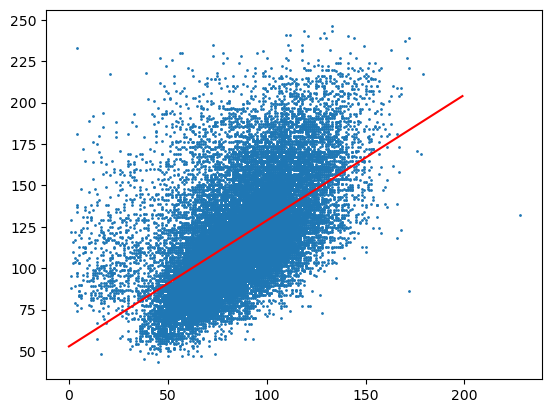

In [15]:
plt.scatter(DF_NOBS, DF_NDOWN, s=1)
plt.plot(np.arange(200)*Nslope+Nintercept, c='r')

In [16]:
Ccorrected = (DF_CDOWN-Cintercept)/Cslope

In [17]:
Cslope_C, Cintercept_C = regresion_v2(DF_COBS, Ccorrected)
Cslope_C, Cintercept_C

(1.000000000000003, -2.4868995751603507e-14)

In [18]:
np.max(Ccorrected)

53.37407378423981

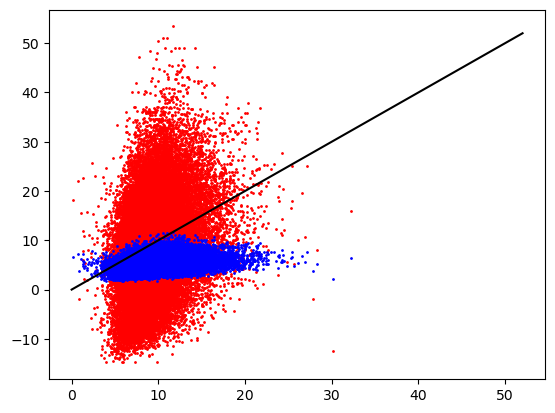

In [19]:
plt.scatter(DF_COBS, Ccorrected, s=1, c='r')
plt.scatter(DF_COBS, DF_CDOWN, s=1, c='b')
plt.plot(np.arange(53)*Cslope_C+Cintercept_C, c='k')
# plt.plot(np.arange(53)*Cslope+Cintercept, c='g')

In [20]:
# Nslope, Nintercept, Nx_line, Ny_line = linear_regression(DF_NOBS, DF_NDOWN)
# Cslope, Cintercept, Cx_line, Cy_line = linear_regression(DF_COBS, DF_CDOWN)
# Wslope, Wintercept, Wx_line, Wy_line = linear_regression(DF_WOBS, DF_WDOWN)

Text(0.0, 1.0, '(c) Shape')

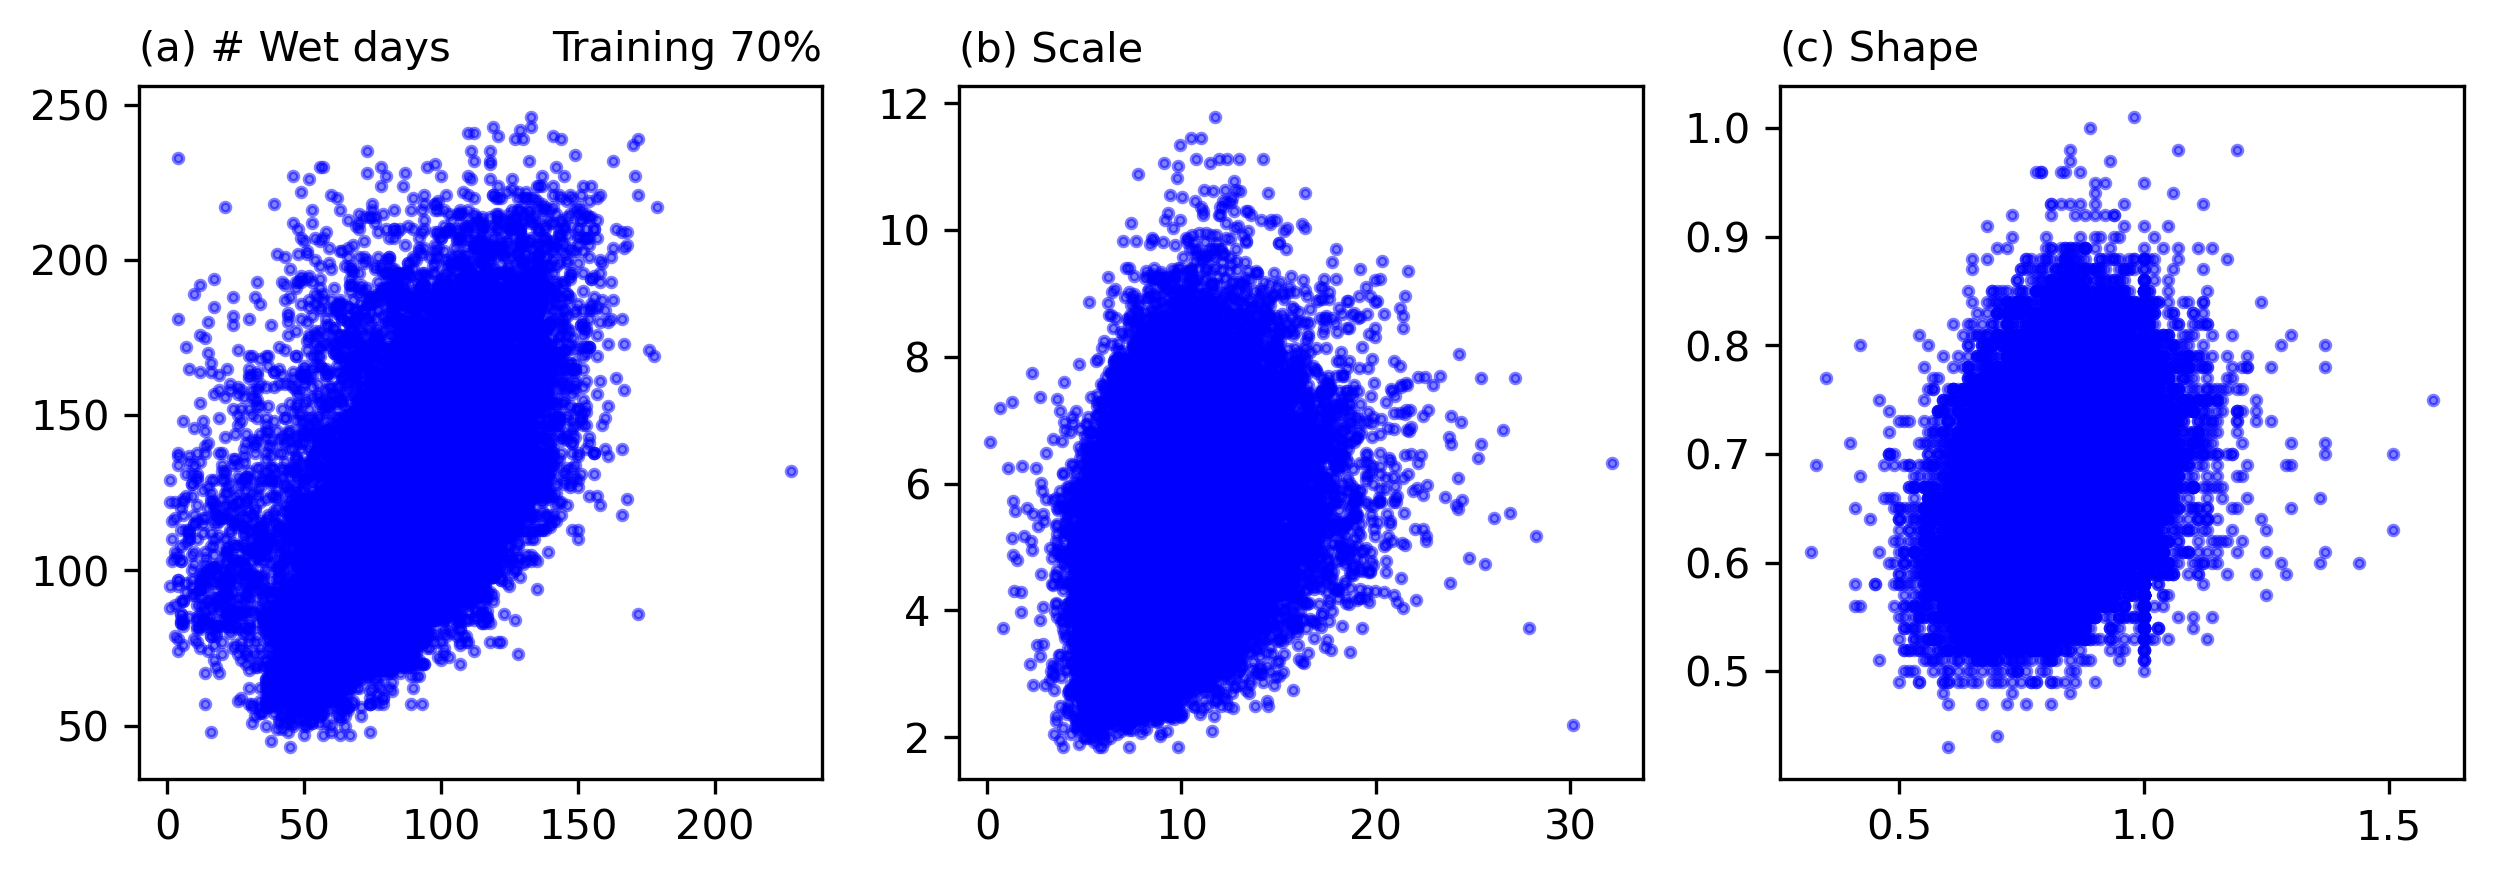

In [21]:
fig = plt.figure(figsize=(10,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# =============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(DF_NOBS, DF_NDOWN, color='blue', s=5, alpha=0.5)
# ax1.plot(Nx_line, Ny_line, color='red', linewidth=1)
ax1.set_title('(a) # Wet days ', loc='left',fontsize=10)
ax1.set_title('Training 70%', loc='right',fontsize=10)

# =============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(DF_COBS, DF_CDOWN, color='blue', s=5, alpha=0.5)
# ax1.plot(Cx_line, Cy_line, color='red', linewidth=1)
ax1.set_title('(b) Scale', loc='left',fontsize=10)

# =============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(DF_WOBS, DF_WDOWN, color='blue', s=5, alpha=0.5)
# ax1.plot(Wx_line, Wy_line, color='red', linewidth=1)
ax1.set_title('(c) Shape', loc='left',fontsize=10)

In [22]:
def Log_linear_test(OBS, SAT):
    obs_log = np.log1p(OBS)
    sat_log = np.log1p(SAT)

    model = LinearRegression()
    # model.fit(sat_log.reshape(-1, 1), obs_log)
    model.fit(obs_log.reshape(-1, 1), sat_log)

    sat_corr_log = model.predict(sat_log.reshape(-1, 1))
    sat_corrected = np.expm1(sat_corr_log)
    
    return sat_corrected

In [23]:
NYd_corrected_log = Log_linear_test(DF_NOBS, DF_NDOWN)
CYd_corrected_log = Log_linear_test(DF_COBS, DF_CDOWN)
WYd_corrected_log = Log_linear_test(DF_WOBS, DF_WDOWN)

In [24]:
# NYd_corrected_test = (DF_NDOWN- Nintercept)/Nslope
# CYd_corrected_test = (DF_CDOWN- Cintercept)/Cslope
# WYd_corrected_test = (DF_WDOWN- Wintercept)/Wslope

(0.32, 1.59)

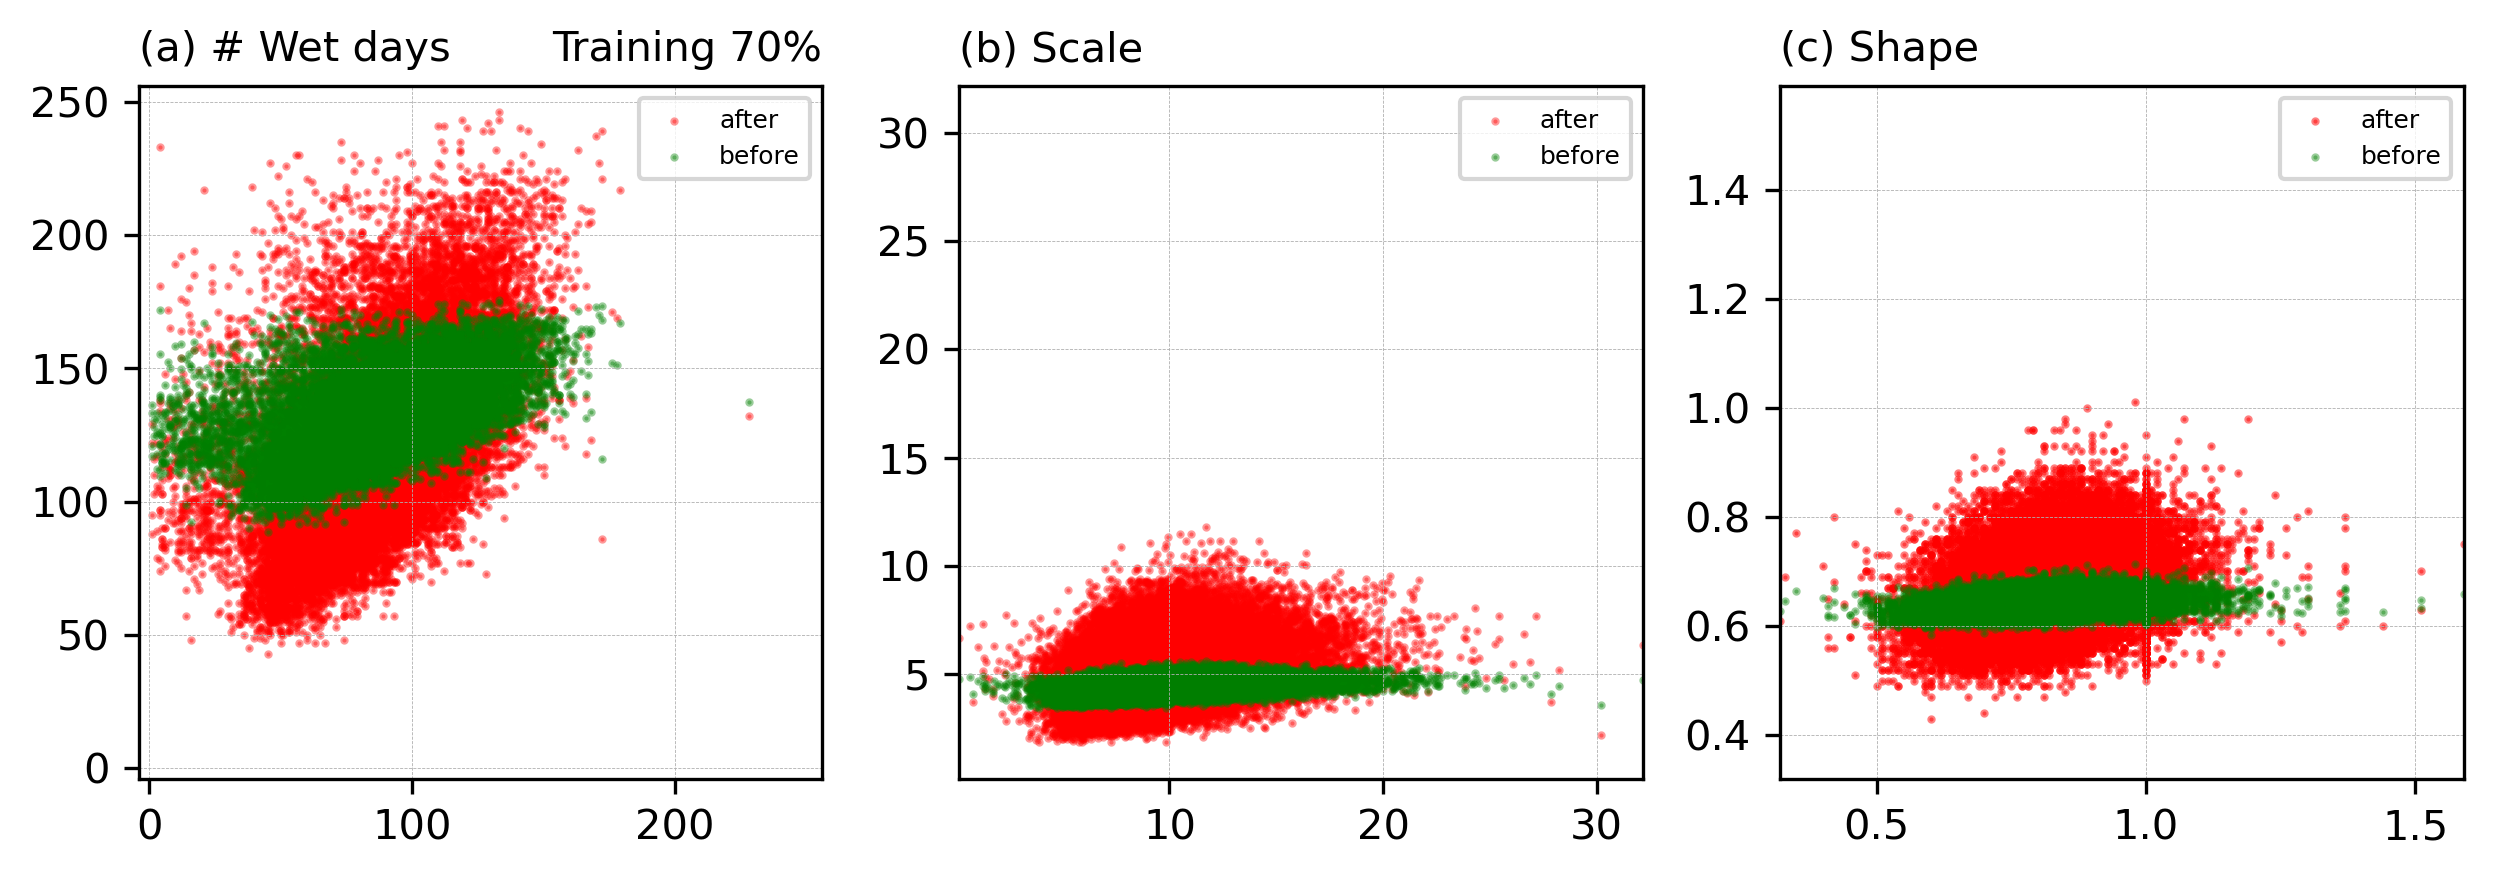

In [25]:
fig = plt.figure(figsize=(10,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# =============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(DF_NOBS, DF_NDOWN, color='r', s=1, alpha=0.4, label='after')
# ax1.scatter(DF_NOBS, NYd_corrected_test, color='g', s=1, alpha=0.1)
ax1.scatter(DF_NOBS, NYd_corrected_log, color='g', s=1, alpha=0.4, label='before')

ax1.set_title('(a) # Wet days ', loc='left',fontsize=10)
ax1.set_title('Training 70%', loc='right',fontsize=10)
ax1.grid(linewidth=0.2, linestyle='--')
ax1.legend(fontsize=6, loc=1)
ax1.set_xlim(np.min(DF_NOBS)-5, np.max(DF_NDOWN)+10)
ax1.set_ylim(np.min(DF_NOBS)-5, np.max(DF_NDOWN)+10)

# =============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(DF_COBS, DF_CDOWN, color='r', s=1, alpha=0.4, label='after')
# ax1.scatter(DF_COBS, CYd_corrected_test, color='g', s=5, alpha=0.1)
ax1.scatter(DF_COBS, CYd_corrected_log, color='g', s=1, alpha=0.4, label='before')

ax1.set_title('(b) Scale', loc='left',fontsize=10)
ax1.grid(linewidth=0.2, linestyle='--')
ax1.legend(fontsize=6, loc=1)
ax1.set_xlim(np.min(DF_COBS), np.max(DF_COBS))
ax1.set_ylim(np.min(DF_COBS), np.max(DF_COBS))

# =============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(DF_WOBS, DF_WDOWN, color='r', s=1, alpha=0.5, label='after')
# ax1.scatter(DF_WOBS, WYd_corrected_test, color='g', s=5, alpha=0.1)
ax1.scatter(DF_WOBS, WYd_corrected_log, color='g', s=1, alpha=0.4, label='before')

ax1.set_title('(c) Shape', loc='left',fontsize=10)
ax1.grid(linewidth=0.2, linestyle='--')
ax1.legend(fontsize=6, loc=1)
ax1.set_xlim(np.min(DF_WOBS), np.max(DF_WOBS))
ax1.set_ylim(np.min(DF_WOBS), np.max(DF_WOBS))

In [26]:
dir_in = os.path.join(sat_base, f'ITALY_DOWN_{product}_{time_reso}_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson.nc')
DATA = xr.open_dataset(dir_in)

lats = DATA.lat
lons = DATA.lon
lon2d, lat2d = np.meshgrid(lons, lats)

italy_geom = ITALY.union_all() # ONLY FOR ITALY
mask_italy = sv.contains(italy_geom, lon2d, lat2d)

Sat_year = DATA.year.values

if product == 'CHIRPS':
    DATA['NYs'] = DATA.NYs.where(DATA.NYs != 0)
    DATA['CYs'] = DATA.CYs.where(DATA.CYs != 0)
    DATA['WYs'] = DATA.WYs.where(DATA.WYs != 0)
    
    DATA['NYd'] = DATA.NYd.where(DATA.NYd != 0)
    DATA['CYd'] = DATA.CYd.where(DATA.CYd != 0)
    DATA['WYd'] = DATA.WYd.where(DATA.WYd != 0)

NYd = DATA.NYd.where(mask_italy).values
CYd = DATA.CYd.where(mask_italy).values
WYd = DATA.WYd.where(mask_italy).values

mask_italy = sv.contains(italy_geom, lon2d, lat2d)
MEVd_CM_clear = DATA.Mev_d.where(mask_italy)

In [71]:
def Log_linear_test_ALL(OBS, SAT, SAT_ALL):
    # 1. Crear el DataFrame
    df = pd.DataFrame({
        'OBS': OBS,
        'SAT': SAT
    })

    # (opcional pero recomendado) eliminar posibles NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Regresión lineal: SAT = slope * OBS + intercept
    result = linregress(df['OBS'], df['SAT'])

    slope = result.slope
    intercept = result.intercept
    
    # sat_corrected = slope * SAT_ALL  + intercept
    sat_corrected = (SAT_ALL  - intercept)/slope
    # sat_corrected = (SAT_ALL)/slope

    return sat_corrected

def bias_correction_log_linear_v2(obs, sat, SAT_ALL):
    log_obs = np.log(obs)
    log_sat = np.log(sat)

    # 1. Crear el DataFrame
    df = pd.DataFrame({
        'OBS': log_obs,
        'SAT': log_sat
    })

    # (opcional pero recomendado) eliminar posibles NaN o inf
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # 2. Regresión lineal: SAT = slope * OBS + intercept
    result = linregress(df['OBS'].values, df['SAT'].values)

    slope = result.slope
    intercept = result.intercept
    
    # log_data_to_correct = np.log1p(SAT_ALL.flatten())
    # log_data_to_correct = log_data_to_correct[~np.isnan(log_data_to_correct)]
    log_corrected = (np.log1p(SAT_ALL) - intercept)/slope
    
    # Regresar a escala original
    corrected_data = np.exp(log_corrected)
    
    return corrected_data

def QDM(obs, sat_hist, sat_all, eps=1e-6):
    """
    Quantile Delta Mapping (QDM) for 1D precipitation series

    Parameters
    ----------
    obs : array-like
        Observed historical data
    sat_hist : array-like
        Satellite/model historical data (same period as obs)
    sat_all : array-like
        Satellite/model data to be corrected (validation or future)
    eps : float
        Small value to avoid numerical issues

    Returns
    -------
    sat_corr : np.ndarray
        Bias-corrected satellite/model data
    """

    # Remove NaNs consistently
    mask = (~np.isnan(obs)) & (~np.isnan(sat_hist))
    obs = obs[mask]
    sat_hist = sat_hist[mask]

    # Sort historical series
    obs_sorted = np.sort(obs)
    sat_sorted = np.sort(sat_hist)

    n = len(sat_sorted)

    # Empirical CDF
    p = (np.arange(1, n + 1) - 0.5) / n

    # Compute quantiles
    sat_q = np.interp(p, p, sat_sorted)
    obs_q = np.interp(p, p, obs_sorted)

    # Output array
    sat_corr = np.full_like(sat_all, np.nan, dtype=float)

    # Loop over SAT_all
    for i, x in enumerate(sat_all):

        if np.isnan(x):
            continue

        # Find quantile of x in sat_hist
        q = np.interp(x, sat_sorted, p, left=p[0], right=p[-1])

        # Quantiles at q
        sat_qx = np.interp(q, p, sat_q)
        obs_qx = np.interp(q, p, obs_q)

        # Delta (multiplicative, best for precipitation)
        delta = (x + eps) / (sat_qx + eps)

        # Apply correction
        sat_corr[i] = obs_qx * delta

    # Physical constraint
    sat_corr = np.maximum(sat_corr, 0.0)

    return sat_corr

import numpy as np

def CDFt(obs, sat_hist, sat_all, eps=1e-6):
    """
    CDF-t bias correction for 1D precipitation series

    Parameters
    ----------
    obs : array-like
        Observed historical data
    sat_hist : array-like
        Satellite/model historical data (same period as obs)
    sat_all : array-like
        Satellite/model data to be corrected (validation or future)
    eps : float
        Small value to avoid numerical issues

    Returns
    -------
    sat_corr : np.ndarray
        Bias-corrected satellite/model data
    """

    # --- Remove NaNs consistently (calibration only)
    mask = (~np.isnan(obs)) & (~np.isnan(sat_hist))
    obs = obs[mask]
    sat_hist = sat_hist[mask]

    # --- Sort historical series
    obs_sorted = np.sort(obs)
    sat_sorted = np.sort(sat_hist)

    n = len(sat_sorted)

    # --- Empirical CDF
    p = (np.arange(1, n + 1) - 0.5) / n

    # --- Output
    sat_corr = np.full_like(sat_all, np.nan, dtype=float)

    # --- Apply CDF-t
    for i, x in enumerate(sat_all):

        if np.isnan(x):
            continue

        # Quantile of x in sat_hist
        q = np.interp(x, sat_sorted, p, left=p[0], right=p[-1])

        # Map through OBS distribution
        sat_corr[i] = np.interp(q, p, obs_sorted)

    # --- Physical constraint
    sat_corr = np.maximum(sat_corr, 0.0)

    return sat_corr


In [72]:
print(f'Correction: {nameout}')
if nameout == 'LRc':
    original_shape = NYd.shape
    mask = ~np.isnan(NYd)
    NYd_clear = NYd[mask]
    NYd_corrected_1d = CDFt(DF_NOBS, DF_NDOWN, NYd_clear)
    NYd_corrected_2d = np.full(original_shape, np.nan)
    NYd_corrected_2d[mask] = NYd_corrected_1d

    original_shape = CYd.shape
    mask = ~np.isnan(CYd)
    CYd_clear = CYd[mask]
    CYd_corrected_1d = CDFt(DF_COBS, DF_CDOWN, CYd_clear)
    CYd_corrected_2d = np.full(original_shape, np.nan)
    CYd_corrected_2d[mask] = CYd_corrected_1d

    original_shape = WYd.shape
    mask = ~np.isnan(WYd)
    WYd_clear = WYd[mask]
    WYd_corrected_1d = CDFt(DF_WOBS, DF_WDOWN, WYd_clear)
    WYd_corrected_2d = np.full(original_shape, np.nan)
    WYd_corrected_2d[mask] = WYd_corrected_1d

elif nameout == 'LLc':
    NYd_corrected = bias_correction_log_linear_v2(DF_NOBS, DF_NDOWN, NYd)
    CYd_corrected = bias_correction_log_linear_v2(DF_COBS, DF_CDOWN, CYd)
    WYd_corrected = bias_correction_log_linear_v2(DF_WOBS, DF_WDOWN, WYd)

elif nameout == 'QDM':
    original_shape = NYd.shape
    mask = ~np.isnan(NYd)
    NYd_clear = NYd[mask]
    NYd_corrected_1d = QDM(DF_NOBS, DF_NDOWN, NYd_clear)
    NYd_corrected_2d = np.full(original_shape, np.nan)
    NYd_corrected_2d[mask] = NYd_corrected_1d

    original_shape = CYd.shape
    mask = ~np.isnan(CYd)
    CYd_clear = CYd[mask]
    CYd_corrected_1d = QDM(DF_COBS, DF_CDOWN, CYd_clear)
    CYd_corrected_2d = np.full(original_shape, np.nan)
    CYd_corrected_2d[mask] = CYd_corrected_1d

    original_shape = WYd.shape
    mask = ~np.isnan(WYd)
    WYd_clear = WYd[mask]
    WYd_corrected_1d = QDM(DF_WOBS, DF_WDOWN, WYd_clear)
    WYd_corrected_2d = np.full(original_shape, np.nan)
    WYd_corrected_2d[mask] = WYd_corrected_1d

elif nameout == 'CDFt':
    original_shape = NYd.shape
    mask = ~np.isnan(NYd)
    NYd_clear = NYd[mask]
    NYd_corrected_1d = CDFt(DF_NOBS, DF_NDOWN, NYd_clear)
    NYd_corrected_2d = np.full(original_shape, np.nan)
    NYd_corrected_2d[mask] = NYd_corrected_1d

    original_shape = CYd.shape
    mask = ~np.isnan(CYd)
    CYd_clear = CYd[mask]
    CYd_corrected_1d = CDFt(DF_COBS, DF_CDOWN, CYd_clear)
    CYd_corrected_2d = np.full(original_shape, np.nan)
    CYd_corrected_2d[mask] = CYd_corrected_1d

    original_shape = WYd.shape
    mask = ~np.isnan(WYd)
    WYd_clear = WYd[mask]
    WYd_corrected_1d = CDFt(DF_WOBS, DF_WDOWN, WYd_clear)
    WYd_corrected_2d = np.full(original_shape, np.nan)
    WYd_corrected_2d[mask] = WYd_corrected_1d

elif nameout == 'QQc':
    mask = ~np.isnan(NYd)
    NYs_valid = NYd[mask]
    NYs_full = ART_sta.ISIMIP_QM_ALL(DF_NOBS, NYs_valid)
    NYd_corrected_2d = np.full(NYd.shape, np.nan)
    NYd_corrected_2d[mask] = NYs_full

    mask = ~np.isnan(CYd)
    CYs_valid = CYd[mask]
    CYs_full = ART_sta.ISIMIP_QM_ALL(DF_COBS, CYs_valid)
    CYd_corrected_2d = np.full(CYd.shape, np.nan)
    CYd_corrected_2d[mask] = CYs_full

    mask = ~np.isnan(WYd)
    WYs_valid = WYd[mask]
    WYs_full = ART_sta.ISIMIP_QM_ALL(DF_WOBS, WYs_valid)
    WYd_corrected_2d = np.full(WYd.shape, np.nan)
    WYd_corrected_2d[mask] = WYs_full

Correction: LLc


In [73]:
Tr = [5,  10,  20,  50, 100, 200]
Mevd = ART_down.pre_quantiles_array(
                            NYd, 
                            CYd, 
                            WYd, 
                            Tr, lats, lons, 1)

Mevd_corrected = ART_down.pre_quantiles_array(
                            NYd_corrected, #NYd_corrected_2d 
                            CYd_corrected, 
                            WYd_corrected, 
                            Tr, lats, lons, 1)

In [74]:
# Tr = np.array(Tr)
# QUANTILE = np.zeros([len(Tr),len(DF_NOBS)])
# for nn in range(len(DF_NOBS)):

#     DF_NOBS_ = np.array(DF_NOBS)[nn]
#     DF_COBS_ = np.array(DF_COBS)[nn]
#     DF_WOBS_ = np.array(DF_WOBS)[nn]

#     Fi = 1 - 1/Tr
#     x0 = 9.0*np.nanmean(DF_COBS)
#     quant, flag = ART_down.mev_quant_update(Fi, x0, 
#                                     DF_NOBS_, 
#                                     DF_COBS_, 
#                                     DF_WOBS_,
#                                     thresh=1)
#     QQ = np.where(flag, quant, np.nan)
#     QUANTILE[:,nn] = QQ

In [75]:
# Mevd_corrected[3,:,:] = np.where(Mevd_corrected[3,:,:]>350, 350, Mevd_corrected[3,:,:])

In [76]:
# Mevd_corrected = np.where(Mevd_corrected<0, 0,Mevd_corrected)

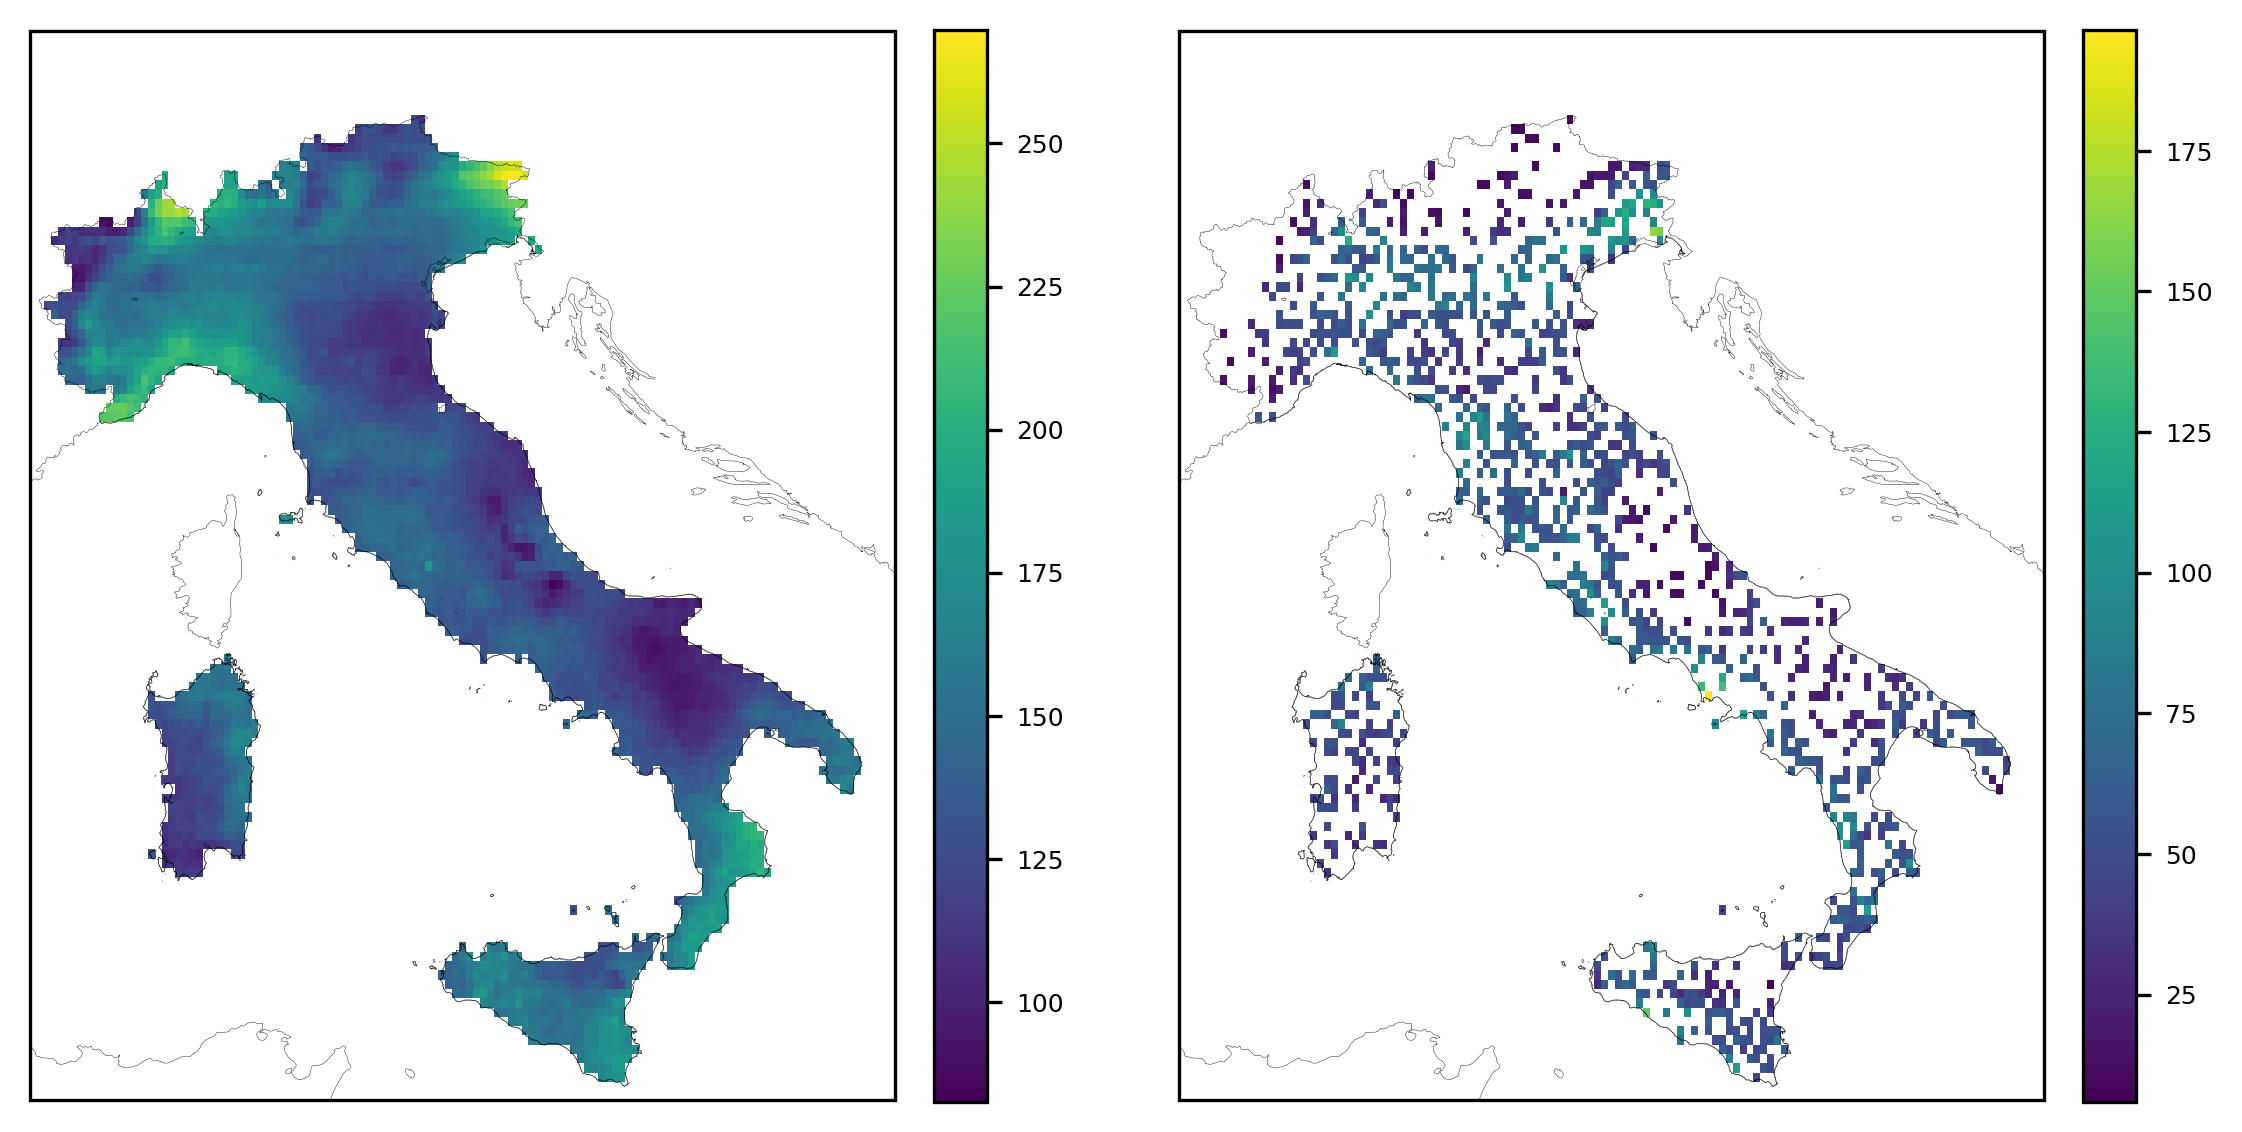

In [77]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(14,9),dpi=300)
gs = gridspec.GridSpec(1,3)

# ========================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ITALY.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, MEVd_CM_clear[3,:,:])
cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04)
cbar.ax.tick_params(labelsize=6)

# ========================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.1,edgecolor='k')
ITALY.plot(legend=False, facecolor="none", edgecolor='black', linewidth=0.1, ax=ax1, zorder=10)
a1 = ax1.pcolormesh(lon2d, lat2d, Mevd_corrected[3,:,:])
cbar = plt.colorbar(a1, ax=ax1, fraction=0.056, pad=0.04)
cbar.ax.tick_params(labelsize=6)

In [ ]:
DOWN_corrected = xr.Dataset(
    data_vars={
        "NYd": (("year","lat","lon"), NYd_corrected_2d),
        "CYd": (("year","lat","lon"), CYd_corrected_2d),
        "WYd": (("year","lat","lon"), WYd_corrected_2d),
        "Mev_d": (("Tr","lat","lon"), Mevd_corrected),
        },
    coords={
        'year': Sat_year, 
        'lat': lats, 
        'lon': lons
        },
        attrs=dict(description=f"{product} Weibull parameters and MEV corrected applying {correction} method using 70% of stations in Italy",))

DOWN_corrected.NYd.attrs["units"] = "# days"
DOWN_corrected.NYd.attrs["long_name"] = "Corrected Downscaled Number of Wet Days"
DOWN_corrected.NYd.attrs["origname"] = "Down Wet Days"

DOWN_corrected.CYd.attrs["units"] = "nondimensional"
DOWN_corrected.CYd.attrs["long_name"] = "Corrected Downscaled Scale Parameter"
DOWN_corrected.CYd.attrs["origname"] = "Down Scale"

DOWN_corrected.WYd.attrs["units"] = "nondimensional"
DOWN_corrected.WYd.attrs["long_name"] = "Corrected Downscaled Shape Parameter"
DOWN_corrected.WYd.attrs["origname"] = "Down Shape"

DOWN_corrected.Mev_d.attrs["units"] = "mm/day"
DOWN_corrected.Mev_d.attrs["long_name"] = "Corrected Downscaled Extreme Quantiles"
DOWN_corrected.Mev_d.attrs["origname"] = "Down Ext-Quant"

DOWN_corrected.lat.attrs["units"] = "degrees_north"
DOWN_corrected.lat.attrs["long_name"] = "Latitude"

DOWN_corrected.lon.attrs["units"] = "degrees_east"
DOWN_corrected.lon.attrs["long_name"] = "Longitude"

# EXPORT AS NETCDF
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')
PRE_out = os.path.join(os.path.join(dir_base, '6_DOWN_BCorrected',apply,nameout, dir_in.split('/')[-1].replace('_pearson',f'_pearson_{nameout}_{str(seed).zfill(4)}')))
print(f'Exportin as: {PRE_out}')
# DOWN_corrected.to_netcdf(PRE_out)

Exportin as: /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/PARAM/LLc/ITALY_DOWN_IMERG_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_LLc_0007.nc


In [36]:
playsound("../sound/HOMER_DOH.mp3")